# Hands-on Tutorial: Numerical Techniques in Advanced Hydraulics

**Course:** Advanced Hydraulics

**Objective:** To bridge the gap between theoretical hydraulic equations and their practical, computational implementation. This session will introduce the core logic behind various numerical methods used to solve common problems in hydraulics.

## 1. Introduction & Setup

Many fundamental equations in hydraulics (like Manning's equation for non-standard channels, the Gradually Varied Flow equation, or the Saint-Venant equations) do not have simple analytical ("pen-and-paper") solutions. We rely on numerical methods to approximate their solutions. 

In this tutorial, we will explore four key areas:

1.  **Root Finding:** Solving implicit non-linear equations, such as finding the normal depth in a trapezoidal channel.
2.  **Numerical Integration:** Calculating total quantities from discrete data, such as the total volume of a flood hydrograph.
3.  **Solving Ordinary Differential Equations (ODEs):** Computing water surface profiles for Gradually Varied Flow (GVF).
4.  **Solving Partial Differential Equations (PDEs):** A simplified model of unsteady flow (1D dam break) using the Saint-Venant equations.

### Required Libraries
We will use `NumPy` for efficient array calculations and `Matplotlib` for plotting our results.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Set a nice style for our plots
plt.style.use('seaborn-v0_8-whitegrid')

--- 
## 2. Root Finding: Solving for Normal Depth

### Introduction

The normal depth, $y_n$, is the depth of uniform flow in an open channel where the bed slope, water surface slope, and energy line slope are all equal. It's determined by **Manning's Equation**:

$$ Q = \frac{1}{n} A R_h^{2/3} s_0^{1/2} $$

Where:
- $Q$: Discharge (m³/s)
- $n$: Manning's roughness coefficient
- $A$: Cross-sectional area (m²)
- $R_h$: Hydraulic radius ($A/P$), where $P$ is the wetted perimeter (m)
- $s_0$: Bed slope

For a simple rectangular channel, this can be solved directly. But for a **trapezoidal channel**, the area ($A$) and wetted perimeter ($P$) are complex functions of depth ($y$), making the equation implicit. 

$A = (b + zy)y$
$P = b + 2y\sqrt{1+z^2}$

We need to find the root $y$ for the function:

$$ f(y) = Q - \frac{1}{n} \frac{((b+zy)y)^{5/3}}{(b+2y\sqrt{1+z^2})^{2/3}} s_0^{1/2} = 0 $$

We will implement two common root-finding algorithms: the **Bisection Method** and the **Newton-Raphson Method**.

### Problem Setup

In [5]:
# Channel and flow parameters
Q = 100  # Discharge (m^3/s)
n = 0.015  # Manning's roughness
s0 = 0.001 # Bed slope
b = 10   # Bottom width (m)
z = 2    # Side slope (2H:1V)

# Define the function f(y) we want to find the root of
def f_manning(y, Q, n, b, z, s0):
    A = (b + z * y) * y
    P = b + 2 * y * np.sqrt(1 + z**2)
    if A <= 0 or P <= 0: return float('inf') # Avoid division by zero for invalid depths
    
    Rh = A / P
    Q_calc = (1/n) * A * Rh**(2/3) * s0**0.5
    return Q - Q_calc

### Implementation 1: Bisection Method

**Concept:** If you have a continuous function and two points, `a` and `b`, where `f(a)` and `f(b)` have opposite signs, a root must exist between them. The method repeatedly bisects the interval `[a, b]` and selects the subinterval that must contain the root.

In [6]:
def bisection_method(f, a, b, tol=1e-6, max_iter=100):
    """Finds a root of function f within the interval [a, b]."""
    if f(a) * f(b) >= 0:
        print("Bisection method fails: f(a) and f(b) must have opposite signs.")
        return None
    
    iter_count = 0
    while (b - a) / 2.0 > tol and iter_count < max_iter:
        c = (a + b) / 2.0
        if f(c) == 0:
            return c
        elif f(a) * f(c) < 0:
            b = c
        else:
            a = c
        iter_count += 1
        
    print(f"Bisection converged in {iter_count} iterations.")
    return (a + b) / 2.0

# We need to provide an initial bracket [a, b]
# Let's try y=0.1m and y=10m
y_low = 0.1
y_high = 10.0

# Create a partial function for easier use
f = lambda y: f_manning(y, Q, n, b, z, s0)

normal_depth_bisection = bisection_method(f, y_low, y_high)
print(f"Normal Depth (Bisection): {normal_depth_bisection:.4f} m")

Bisection converged in 23 iterations.
Normal Depth (Bisection): 2.3117 m


### Implementation 2: Newton-Raphson Method

**Concept:** Starts with an initial guess and iteratively improves it using the tangent to the function. It's much faster than bisection but requires the derivative of the function, $f'(y)$, and can be unstable if the initial guess is poor.

$$ y_{i+1} = y_i - \frac{f(y_i)}{f'(y_i)} $$

The derivative $f'(y)$ is complex to derive analytically, so we'll approximate it numerically using a central difference: 

$$ f'(y) \approx \frac{f(y+h) - f(y-h)}{2h} $$

In [7]:
def numerical_derivative(f, y, h=1e-6):
    """Calculates the numerical derivative of f at y."""
    return (f(y + h) - f(y - h)) / (2 * h)

def newton_raphson_method(f, y0, tol=1e-6, max_iter=50):
    """Finds a root of function f starting with guess y0."""
    y = y0
    iter_count = 0
    for i in range(max_iter):
        f_y = f(y)
        if abs(f_y) < tol:
            break
        
        fp_y = numerical_derivative(f, y)
        if fp_y == 0:
            print("Newton-Raphson fails: Derivative is zero.")
            return None
        
        y = y - f_y / fp_y
        iter_count = i + 1
        
    print(f"Newton-Raphson converged in {iter_count} iterations.")
    return y

# Let's start with an initial guess, e.g., y=2.0m
y_initial_guess = 2.0

normal_depth_newton = newton_raphson_method(f, y_initial_guess)
print(f"Normal Depth (Newton-Raphson): {normal_depth_newton:.4f} m")

Newton-Raphson converged in 3 iterations.
Normal Depth (Newton-Raphson): 2.3117 m


### Discussion & Real-World Approach

- **Bisection:** Robust and guaranteed to converge if properly bracketed, but slow.
- **Newton-Raphson:** Very fast (quadratic convergence) if the initial guess is good, but can diverge. Requires a derivative.

In practice, you would use a highly optimized and robust solver from a library like `SciPy`.

In [ ]:
from scipy.optimize import newton
 # The newton function in scipy can use the Secant method if a derivative isn't provided.
scipy_result = newton(f, 2.0)
print(f"Normal Depth (SciPy): {scipy_result:.4f} m")

--- 
## 3. Numerical Integration: Calculating Flood Volume

### Introduction
A common task is to calculate the total volume of water that passes a point during a flood event. We are usually given a **hydrograph**, which is a time-series of discharge ($Q$) measurements.

The total volume ($V$) is the integral of the discharge over time:

$$ V = \int_{t_0}^{t_f} Q(t) \,dt $$

Since we have discrete data points, not a continuous function, we must use numerical integration. The simplest and most common method is the **Trapezoidal Rule**.

### Problem Setup
Let's create a sample flood hydrograph.

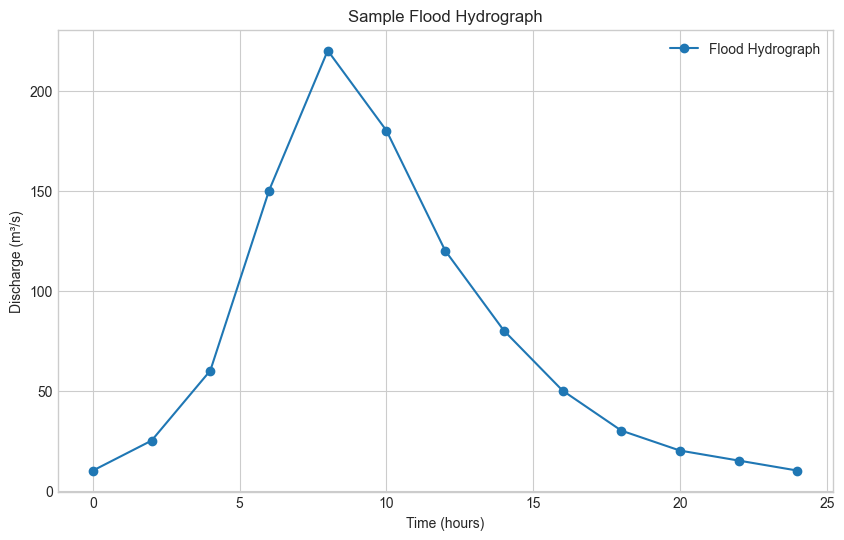

In [8]:
# Time in hours, from 0 to 24 hours, every 2 hours
time_hr = np.array([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24])
# Corresponding discharge in m^3/s
discharge_m3s = np.array([10, 25, 60, 150, 220, 180, 120, 80, 50, 30, 20, 15, 10])

# Plot the hydrograph to visualize it
plt.figure(figsize=(10, 6))
plt.plot(time_hr, discharge_m3s, '-o', label='Flood Hydrograph')
plt.title('Sample Flood Hydrograph')
plt.xlabel('Time (hours)')
plt.ylabel('Discharge (m³/s)')
plt.grid(True)
plt.legend()
plt.show()

### Implementation: Trapezoidal Rule

**Concept:** Approximate the area under the curve between two points as a trapezoid. The total area is the sum of the areas of all the small trapezoids.

Area of one trapezoid: $ A_i = \frac{Q_i + Q_{i+1}}{2} \Delta t $

**Important:** Our time is in hours, but discharge is in seconds. We must convert units consistently! Let's convert time to seconds.

In [9]:
def trapezoidal_rule(y_values, x_values):
    """Integrates y with respect to x using the trapezoidal rule."""
    total_volume = 0.0
    for i in range(len(x_values) - 1):
        # Calculate the width of the trapezoid (delta_t)
        dx = x_values[i+1] - x_values[i]
        # Calculate the average height of the trapezoid
        avg_height = (y_values[i] + y_values[i+1]) / 2
        # Add the area of this trapezoid to the total
        total_volume += avg_height * dx
    return total_volume

# First, convert time from hours to seconds
time_s = time_hr * 3600

# Calculate volume using our from-scratch function
total_volume_manual = trapezoidal_rule(discharge_m3s, time_s)

print(f"Total Flood Volume (Manual): {total_volume_manual:,.2f} m³")

# For comparison, the real-world approach using NumPy is much simpler:
total_volume_numpy = np.trapezoid(discharge_m3s, x=time_s)
print(f"Total Flood Volume (NumPy):  {total_volume_numpy:,.2f} m³")

# The result is identical, but the NumPy implementation is highly optimized and preferred.

Total Flood Volume (Manual): 6,912,000.00 m³
Total Flood Volume (NumPy):  6,912,000.00 m³


--- 
## 4. Ordinary Differential Equations (ODEs): Gradually Varied Flow Profile

### Introduction

Gradually Varied Flow (GVF) describes the steady, non-uniform flow where the water depth changes gradually along the length of a channel. The governing equation is a first-order ODE:

$$ \frac{dy}{dx} = \frac{S_0 - S_f}{1 - Fr^2} $$

Where:
- $dy/dx$: Rate of change of depth $y$ with respect to distance $x$
- $S_0$: Bed slope
- $S_f$: Friction slope, calculated from Manning's equation: $S_f = (\frac{nQ}{AR_h^{2/3}})^2$
- $Fr$: Froude number: $Fr = \frac{V}{\sqrt{gD}}$, where $D$ is hydraulic depth ($A/T$, $T$ is top width)

We can solve this ODE to find the water surface profile, for example, the backwater curve (M1 profile) upstream of a dam. We will start at a known depth (a boundary condition) and "march" upstream, calculating the new depth at each step. We will implement the simple **Euler Method** and the more accurate **4th-Order Runge-Kutta (RK4) Method**.

### Problem Setup
Let's model the backwater profile in a rectangular channel upstream of a sluice gate that causes the depth to be 5m.

In [11]:
# Channel and flow parameters for GVF
Q_gvf = 50      # Discharge (m^3/s)
n_gvf = 0.013   # Manning's n
b_gvf = 10      # Channel width (rectangular)
S0_gvf = 0.0005  # Bed slope (mild slope)
g = 9.81        # Gravity

# The GVF function dy/dx = f(y)
def dydx_gvf(y):
    A = b_gvf * y
    P = b_gvf + 2 * y
    Rh = A / P
    V = Q_gvf / A
    
    # Friction Slope
    Sf = (n_gvf * V / (Rh**(2/3)))**2
    
    # Froude Number Squared
    Fr2 = V**2 / (g * y) # For rectangular channel, D=y
    
    # Handle the critical depth singularity
    if abs(1 - Fr2) < 1e-6:
        return float('inf')
    
    return (S0_gvf - Sf) / (1 - Fr2)

### Implementation 1: Euler's Method

**Concept:** The simplest possible ODE solver. It approximates the next value using the slope at the current point.

$$ y_{i+1} = y_i + \Delta x \cdot f(y_i) $$ 

Since we are calculating an M1 profile (backwater), we start at a downstream control and march *upstream*. This means our step `dx` will be negative.

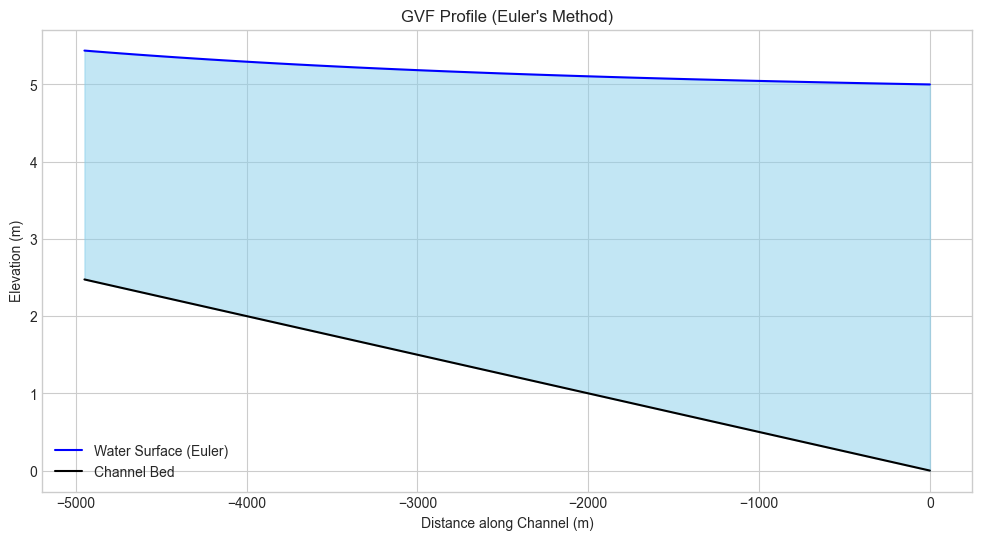

In [12]:
def euler_solver(f, y0, x_span, dx):
    """Solves dy/dx = f(y) using Euler's method."""
    x = np.arange(x_span[0], x_span[1], dx)
    y = np.zeros(len(x))
    y[0] = y0
    
    for i in range(len(x) - 1):
        y[i+1] = y[i] + dx * f(y[i])
        
    return x, y

# Simulation parameters
y_downstream = 5.0  # Depth at the dam/gate (x=0)
x_start = 0
x_end = -5000       # We want to compute the profile 5km upstream
dx = -50            # Step size (negative because we go upstream)

# Solve for depth profile
x_euler, y_euler = euler_solver(dydx_gvf, y_downstream, (x_start, x_end), dx)

# Calculate bed and water surface elevations (assuming bed elevation at x=0 is 0m)
bed_elev_euler = -S0_gvf * x_euler
wse_euler = bed_elev_euler + y_euler # Water Surface Elevation = Bed Elevation + Depth

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(x_euler, wse_euler, 'b-', label="Water Surface (Euler)")
plt.plot(x_euler, bed_elev_euler, 'k-', label="Channel Bed")
plt.fill_between(x_euler, wse_euler, bed_elev_euler, color='skyblue', alpha=0.5)

plt.title('GVF Profile (Euler\'s Method)')
plt.xlabel('Distance along Channel (m)')
plt.ylabel('Elevation (m)')
plt.legend()
plt.grid(True)
plt.show()

### Implementation 2: 4th-Order Runge-Kutta (RK4)

**Concept:** A much more accurate method that uses a weighted average of slopes at four points within the step to make a better estimate.

$k_1 = f(y_i)$ <br>
$k_2 = f(y_i + 0.5 \Delta x \cdot k_1)$ <br>
$k_3 = f(y_i + 0.5 \Delta x \cdot k_2)$ <br>
$k_4 = f(y_i + \Delta x \cdot k_3)$ <br>
$y_{i+1} = y_i + \frac{\Delta x}{6}(k_1 + 2k_2 + 2k_3 + k_4)$ <br>

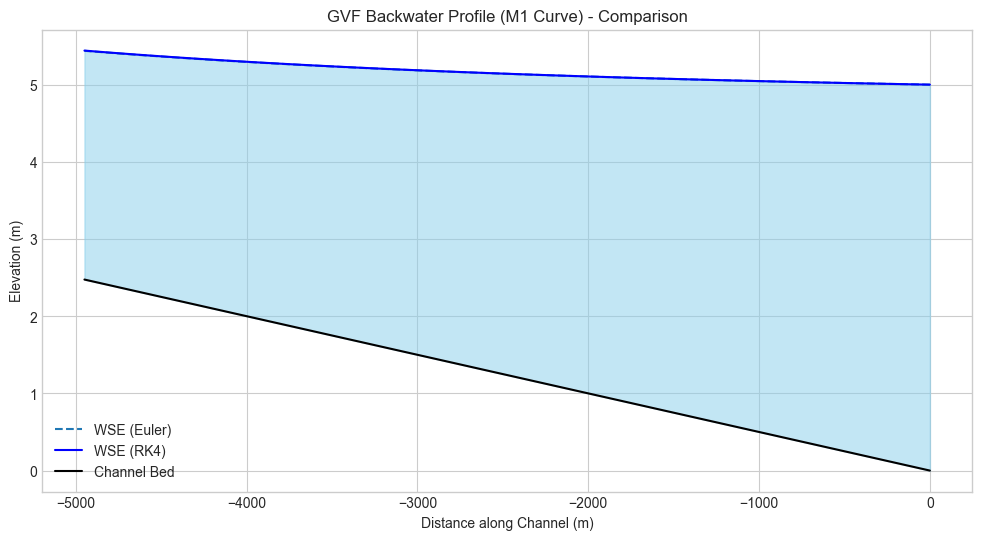

In [13]:
def rk4_solver(f, y0, x_span, dx):
    """Solves dy/dx = f(y) using the RK4 method."""
    x = np.arange(x_span[0], x_span[1], dx)
    y = np.zeros(len(x))
    y[0] = y0
    
    for i in range(len(x) - 1):
        k1 = f(y[i])
        k2 = f(y[i] + 0.5 * dx * k1)
        k3 = f(y[i] + 0.5 * dx * k2)
        k4 = f(y[i] + dx * k3)
        y[i+1] = y[i] + (dx / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        
    return x, y

# Solve for depth profile using RK4
x_rk4, y_rk4 = rk4_solver(dydx_gvf, y_downstream, (x_start, x_end), dx)

# Calculate bed and water surface elevations for the RK4 results
bed_elev_rk4 = -S0_gvf * x_rk4
wse_rk4 = bed_elev_rk4 + y_rk4

# Plot both results for comparison
plt.figure(figsize=(12, 6))
plt.plot(x_euler, wse_euler, '--', label="WSE (Euler)")
plt.plot(x_rk4, wse_rk4, 'b-', label="WSE (RK4)")
plt.plot(x_rk4, bed_elev_rk4, 'k-', label="Channel Bed")
plt.fill_between(x_rk4, wse_rk4, bed_elev_rk4, color='skyblue', alpha=0.5)

plt.title('GVF Backwater Profile (M1 Curve) - Comparison')
plt.xlabel('Distance along Channel (m)')
plt.ylabel('Elevation (m)')

# NOTE: The x-axis is now in its natural orientation. 
# The upstream end (x=-5000m) is on the left, and the downstream control (x=0) is on the right.

plt.legend()
plt.grid(True)
plt.show()

# For real-world use, scipy.integrate.solve_ivp is the standard tool.

--- 
## 5. Partial Differential Equations (PDEs): 1D Unsteady Flow (Dam Break)

### Introduction

This is the most advanced topic. Unsteady flow is described by the **Saint-Venant Equations**, a pair of non-linear hyperbolic PDEs. We'll use the 1D conservative form (assuming a wide rectangular channel, so $A=bh$ and we can analyze per unit width):

**Continuity:** $ \frac{\partial h}{\partial t} + \frac{\partial (hu)}{\partial x} = 0 $

**Momentum:** $ \frac{\partial (hu)}{\partial t} + \frac{\partial (hu^2 + \frac{1}{2}gh^2)}{\partial x} = gh(S_0 - S_f) $

To solve these, we use a **Finite Difference Method**. We discretize both time ($t$) and space ($x$) into a grid. We will implement the **Lax-Friedrichs scheme**, which is an explicit scheme known for its simplicity and relative stability (due to numerical diffusion).

The core idea is to update the state at grid point $j$ and time step $n+1$ based on the states at neighboring points ($j-1, j+1$) at the current time step $n$.

A critical concept for explicit schemes is the **Courant-Friedrichs-Lewy (CFL) condition** for stability:

$$ C = \frac{(|u| + c) \Delta t}{\Delta x} \le 1 $$ 

Where $c = \sqrt{gh}$ is the celerity of a shallow water wave. This means our time step $\Delta t$ must be small enough that information doesn't travel more than one spatial step $\Delta x$ in a single time step.

### Problem Setup: 1D Dam Break
We'll simulate the classic dam break problem in a frictionless, horizontal channel ($S_0=0, S_f=0$).

In [ ]:
# Simulation Parameters
L = 1000      # Length of the channel (m)
Nx = 201      # Number of spatial grid points
dx = L / (Nx - 1) # Spatial step size
g = 9.81

# Initial Conditions
h = np.ones(Nx) * 2.0  # Initial depth
h[:int(Nx/2)] = 10.0   # High water level upstream of the 'dam'
u = np.zeros(Nx)       # Initial velocity is zero everywhere
hu = h * u             # Initial discharge per unit width

# Time parameters
t = 0
t_final = 40 # Total simulation time (s)
CFL = 0.5    # Courant number (must be <= 1)

# Store results for animation
h_results = [h.copy()]
x_grid = np.linspace(0, L, Nx)
t_results = [t]

# --- Main Simulation Loop ---
while t < t_final:
    # --- Calculate dynamic time step based on CFL condition ---
    # We need to find the max wave speed in the whole domain
    c = np.sqrt(g * h)
    max_wave_speed = np.max(np.abs(u) + c)
    if max_wave_speed == 0:
        # If the water is still, use a small arbitrary dt to start things
        dt = CFL * dx / 1.0
    else:
        dt = CFL * dx / max_wave_speed
    
    # Ensure we don't overshoot the final time
    if t + dt > t_final:
        dt = t_final - t

    # --- Store old values ---
    h_old = h.copy()
    hu_old = hu.copy()
    
    # --- Define the 'Fluxes' F1 and F2 ---
    F1 = hu_old
    F2 = hu_old**2 / h_old + 0.5 * g * h_old**2

    # --- Lax-Friedrichs Scheme Update ---
    # Note: we loop from 1 to Nx-1 to handle boundaries easily
    for j in range(1, Nx - 1):
        # Update h (continuity)
        h[j] = 0.5 * (h_old[j+1] + h_old[j-1]) - (dt / (2 * dx)) * (F1[j+1] - F1[j-1])
        
        # Update hu (momentum)
        hu[j] = 0.5 * (hu_old[j+1] + hu_old[j-1]) - (dt / (2 * dx)) * (F2[j+1] - F2[j-1])
        
    # --- Update Boundary Conditions (simple transmissive / zero-gradient) ---
    h[0] = h[1]
    hu[0] = hu[1]
    h[-1] = h[-2]
    hu[-1] = hu[-2]

    # --- Update velocity and time ---
    u = hu / h
    t += dt
    
    # Store results
    h_results.append(h.copy())
    t_results.append(t)

print(f"Simulation finished after {len(t_results)} time steps.")

### Visualization of Dam Break
Now we can animate the results to see the wave propagation.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlim(0, L)
ax.set_ylim(0, 12)
ax.set_xlabel('Channel Distance (m)')
ax.set_ylabel('Water Depth (m)')
ax.set_title('1D Dam Break Simulation')

line, = ax.plot([], [], lw=2)
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

def animate(i):
    # To make animation faster, we can skip frames
    frame_skip = 5
    idx = i * frame_skip
    if idx >= len(h_results):
        idx = len(h_results) - 1
        
    line.set_data(x_grid, h_results[idx])
    time_text.set_text(f'Time = {t_results[idx]:.2f} s')
    return line, time_text

# Create animation
# The number of frames is total results divided by our skip factor
anim = FuncAnimation(fig, animate, init_func=init,
                     frames=len(h_results) // 5, interval=50, blit=True)

# Display the animation in the notebook
plt.close() # Prevents static plot from showing up
HTML(anim.to_jshtml())

### Discussion

This is a very simplified model!
- **Numerical Diffusion:** The Lax-Friedrichs scheme artificially smooths out sharp fronts. The wave front should be steeper. More advanced schemes like Godunov-type schemes are needed to capture shocks accurately.
- **Limitations:** We ignored friction and bed slope, which are crucial in real-world applications.
- **Real Software:** Professional software like HEC-RAS, MIKE, or TUFLOW use much more sophisticated and stable numerical schemes (often Finite Volume methods) and handle complex geometries, boundary conditions, and structures.

However, this simple implementation powerfully demonstrates the core principles of discretizing and solving the governing equations of unsteady flow.

--- 
## 6. Conclusion & Further Learning

Today we have seen how to implement the logic for four fundamental numerical tasks in hydraulics from scratch:

1.  **Finding roots** of non-linear equations.
2.  **Integrating** discrete data to find total quantities.
3.  **Solving ODEs** to model steady-state profiles.
4.  **Solving PDEs** to simulate dynamic, unsteady events.

Understanding these building blocks is key to appreciating how complex hydraulic modeling software works and to developing your own specialized computational tools.

### Recommended Resources:
- **Textbooks:**
    - *Open-Channel Flow* by M. Hanif Chaudhry
    - *Numerical Modeling of Free-Surface and Pressurized Flows* by P.A. Sleigh, P.H. Gaskell, et al.
- **Python Libraries:**
    - **SciPy:** For robust, production-ready functions for integration (`scipy.integrate`), optimization/root-finding (`scipy.optimize`), and more.
- **Further Exploration:**
    - Try implementing a different scheme for the dam break problem (e.g., Leapfrog or MacCormack).
    - Add friction and slope to the Saint-Venant solver.
    - Model a different GVF profile, like an S1 or M2 curve.